# Project TreeBeard 
## An Open Source Solution to Quantifyng Tree Patterns in Forest Land

### Objectives

The objective of Treebeard is to automate the classification and quantification of land cover from raster mosaic datasets in forested areas. The final product is intended to a be a free open-source GIS plugin  that runs on a python base.  It is intended for users wanting a categorial map of features and open spaces in areas with high densities of trees.  Such a tool would prove valuable to managers in forestry as it would allow them to process information for sizeable tracts of land to identify areas that may need treatment or brush clearing. It could be used to report spatial statistics of stands already undergoind treatment. This would hopefully save time and budget costs by removing the need to manually delineate certain types of spaces by spectral signature, and allowing the user to then run selected computations to report spatial heterogenity characteristics.

For this particular study, we will be interested in using our current methods to evaluate the spatial heterogenity in a few sites currently undergoing study in the Lefthand Creek Watershed neard Boulder, Colorado. 
We aim to use unsupervised clustering methods such as k-means on high resolution aerial photogrpahy of the study site to identify specific tree cluster patterns in the landscape.  After that, we plan to bolster this with canopy height models derived from available LiDAR data at the study site.  This would then allow us to create and designate polygons of the immedaite areas of certain stands  --- which could then allow for quick calcualtions of spatial composition, much faster than processing the mosaic data or manually specifying the areas in a shape file.  



Background
----------

### Importance of Spatial Heterogeneity

Spatial heterogeneity is a critical factor in assessing the health of an ecosystem. It is commonly utilized to monitor the distribution of tree species, respond to pollutants and diseases among plant populations, and support hydrological studies that assess potential flood paths. Additionally, it plays a crucial role in evaluating and mitigating the risk of wildfires by forest managers.

### Application in Landscape Analysis

In this project, our focus is on measuring spatial heterogeneity in terms of the distribution of tree groups within the landscape. Specifically, we aim to identify various areas where trees are clustered together in formations ranging from small copses to larger stands. The arrangement and density of these stands are significant as they influence several ecological dynamics, including the patterns of wind flow through the area. When combined with variables such as brush density and canopy overlap, these factors become critical indicators of an area's susceptibility to wildfires.

### Impact of Human Activity

It is also vital to acknowledge that aerial surveys may capture spatial heterogeneity resulting from human activities, such as land development or resource extraction. These anthropogenic influences often introduce different patterns of spatial composition and configuration compared to those arising from natural processes. A primary goal in forestry management is to restore the land to a condition similar to its pre-European settlement state in North America, believed to represent the most unmodified and stable ecological environment.

Study Site Overview
-------------------

### Left-hand Creek Watershed

The study site is located in the Left-hand Creek Watershed. This section of the report will describe the specific area and its forest biome characteristics. The watershed serves as a significant ecological area that supports diverse plant and animal species and plays a crucial role in the local hydrological cycle.

The area exists within the Rocky Mountains to the north of Boulder, CO. It featrues moutainaous terrain at a high elevation, with a contiental climate that features large differences in day and night temperature due to high elevation. It is a highly wooded area, with some small rural devleopments found throughout. It is a home to a diverse set of plant and animal life. The area is currently undergoing restoration projects on some of its local streams.

![Lefthand Creek](images/left_hand_creek.png)

## Data Sources
### Shape files
Shape files for the project area of interest were provided by Eric Frederik of the Watershed Center. They indicate sections of land currently under observation by the Watershed Center. These are available as vector polygons in a vareity of machine-readable file formats.

### Aerial Data
Aerial Data was taken by the Denver Regional Counsel of Governance as part of the Denver Regional Aerial Photography Project (DRAPP) taken every two years.  This is stored on the regional catalog on the [DRCOG website.](https://data.drcog.org/data?page=1&program%5b0%5d=Denver%20Regional%20Aerial%20Photography%20Project&q=&sort=dataVintage)  The resoultion for most of the project is 12 in per pixel.  This data contains four individual spectral bands: red, green, blue, and near infrared -- these are important for calculating  spectral signatures of the areas within the photo.  We are using the 2929 version of the dataset as that is the most recent set freely available to the public. 


### LiDAR Data
LiDar data was also obtained through the DRCOG.  We took our data from the DRCOG LIDAR QL2 INDEX IN CO SP NORTH 2020 set.  This contained mostly point-cloud data that would need to be porcessed into DEM.  Because our area of interest is rural, we must use the QL2 set, which is a qaulity later that will result in a 1 meter cell size in any resulting DEMS.  



## Methods
### Importing Packages And Data

In [22]:
import os
import warnings
import zipfile

import contextily as ctx
import cv2
import earthpy as et
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import hvplot as hv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from ipyleaflet import Map
from leafmap import leafmap
from localtileserver import get_leaflet_tile_layer, TileClient
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
import requests
from samgeo import overlay_images, SamGeo, tms_to_geotiff, get_basemaps
from shapely.geometry import box, Point, shape
from sklearn.cluster import KMeans
from IPython.display import Image


warnings.filterwarnings("ignore")

# Imports for Lidar (merge later)

In [3]:
import math
import os
import subprocess
from glob import glob
from itertools import combinations
from urllib.error import URLError

import earthpy as et
import earthpy.appeears as etapp
import geopandas as gpd
import holoviews as hv
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdal
import requests
import rasterio
import rioxarray as rxr
import rioxarray.merge as rxrm
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from IPython.display import Image
import xarray as xr
import xrspatial
import warnings
import zipfile

from osgeo import gdal, gdal_array, osr
from rasterio.transform import from_origin
from scipy.interpolate import griddata
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import binary_erosion, label
from shapely.geometry import Polygon

In [3]:
shape_file_path = 'assets/areas/immediate_project/Zumwinkel_property.shp'
aoi_gdf = gpd.read_file(shape_file_path)

In [6]:
# Define directories and filepaths
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'treebeard')

# Data Set #1: Denver Regional Aerial Imagery Boundary
drapp_url = (
    'https://gisdata.drcog.org:8443'
    '/geoserver/DRCOGPUB/ows?'
    'service=WFS&version=1.0.0&'
    'request=GetFeature&'
    'typeName=DRCOGPUB:drapp_tile_scheme_2020'
    '&outputFormat=SHAPE-ZIP'
)
drapp_shp_file = os.path.join(data_dir, 'drapp_tile_scheme_2020', 'drapp_tile_scheme_2020.shp')
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')

# Data Set #2: Denver Regional Aerial Imagery Tiles
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

In [12]:
if not os.path.exists(drapp_shp_file):
    drapp_resp = requests.get(drapp_url)
else:
    print(f'Data {drapp_shp_file.split("/")[-1]} already downloaded.')

Data drapp_tile_scheme_2020.shp already downloaded.


In [8]:
def extract_zip(target_dir, zip_filename, resp):
    zip_path = os.path.join(data_dir, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(resp.content)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

In [14]:
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')
if not os.path.exists(drapp_shp_file):
    extract_zip(data_dir, 'drapp_tile_scheme_2020.zip', drapp_resp)
else:
    print(f'Data {drapp_shp_file.split("/")[-1]} already extracted.')

Data drapp_tile_scheme_2020.shp already extracted.


## DATA SCHEMA
In the follwing cells, we create geodataframes for the Area of interest (aoi) and the associated aerial imagery tile.  We also verify tehir coordiante reference system to make sure they align properly.

In [14]:
aoi_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
bbox_aoi_gdf = gpd.GeoDataFrame(geometry=aoi_gdf.bounds.apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1))
bbox_aoi_gdf.crs = aoi_gdf.crs
drapp_gdf = gpd.read_file(drapp_shp_file)
drapp_gdf = drapp_gdf.to_crs(aoi_gdf.crs) # EPSG:6428 -> EPSG:4326

In [16]:
drapp_aoi_gdf = gpd.sjoin(drapp_gdf, aoi_gdf, how='inner', predicate='intersects')

In [17]:
drapp_aoi_gdf

,project,area,resolution,tile,photo_date,storage,geometry,index_right,Shape_Leng,Shape_Area
8979,2020,3,12 Inch,N4W351,20200711,drapparchive,"POLYGON ((-105.52309 40.23444, -105.54200 40.2...",0,0.017313,0.000015


## Plotting
Below we generate a simple plot to show the tile plotted against the shape of the AoI on a spatial grid.

In [18]:
aoi_plot = aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=1, 
        height=800, width=800, color='red',
        label='Area of Interest'
    )
aoi_bound_plot = bbox_aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=0.7, 
        color='blue',
        label='AOI Bounding Box'
    )
drapp_plot = drapp_aoi_gdf.hvplot(
        geo=True, tiles='OSM', 
        alpha=0.3, color='blue',
        hover_cols=['tile', 'photo_date'],
        title='Area of Interest in DRAPP Tile N4W351'
    )
composite_plot = aoi_bound_plot * drapp_plot * aoi_plot

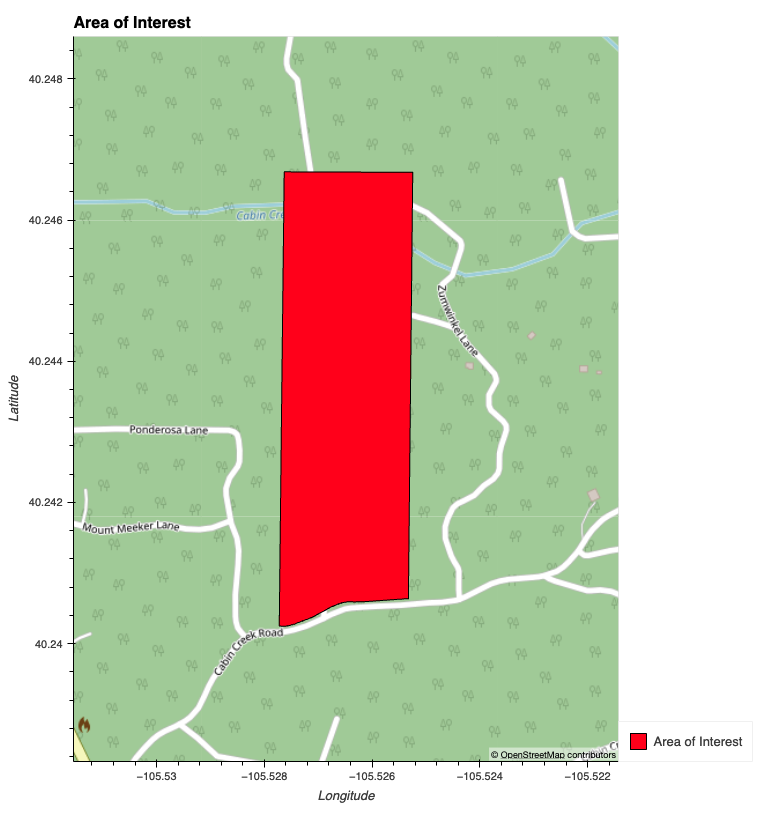

In [24]:
Image("images/aoi_plot.png")

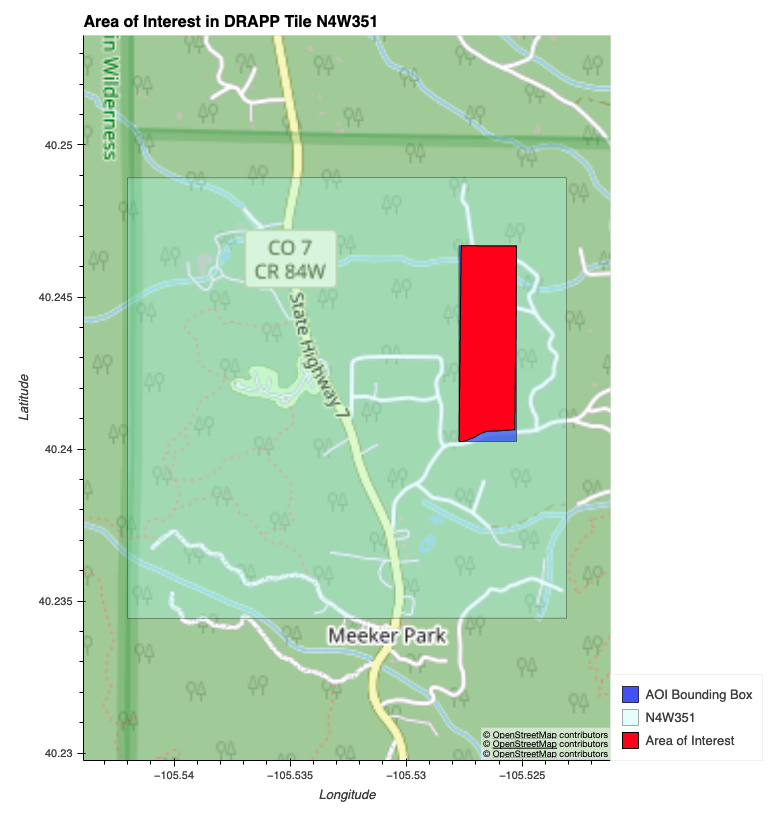

In [23]:
Image("images/composite_plot.png")

In [21]:
tile_base_url = 'https://drapparchive.s3.amazonaws.com/2020/'
tile_urls = [f'{tile_base_url}{tile}.tif' for tile in drapp_aoi_gdf['tile'].unique()]

In [22]:
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

def download_files(urls):
    paths = []
    for url in urls:
        filename = os.path.basename(url)
        path = os.path.join(drapp_tiles_dir, filename)
        paths.append(path)
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            resp = requests.get(url)
            with open(path, 'wb') as f:
                f.write(resp.content)
        else:
            print(f"File {filename} already downloaded.")
    return paths
tile_paths = download_files(tile_urls)

File N4W351.tif already downloaded.


In [23]:
photo_date = pd.to_datetime(
        drapp_aoi_gdf['photo_date']
    ).dt.date.unique()[0].strftime('%Y-%m-%d')
tile_name = drapp_aoi_gdf['tile'].unique()[0]

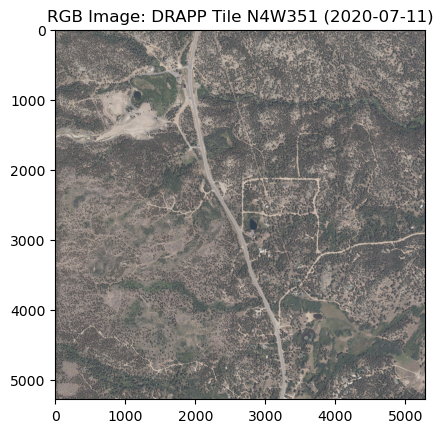

In [25]:
# Open all the files
src_files_to_mosaic = [rasterio.open(path) for path in tile_paths]
mosaic, out_trans = merge(src_files_to_mosaic)
red = mosaic[0]
green = mosaic[1]
blue = mosaic[2]
nir = mosaic[3]
rgb = np.dstack((red, green, blue))
plt.imshow(rgb)
plt.title(f'RGB Image: DRAPP Tile {tile_name} ({photo_date})')
plt.savefig('images/N4W351_rgb_image.png')
plt.show()

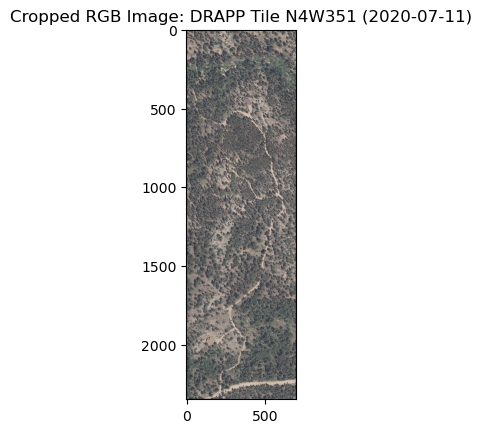

In [26]:
# Open the GeoTIFF file
with rasterio.open(tile_paths[0]) as src:
    # Make sure the GeoDataFrame's CRS matches the raster's CRS
    # Raster: EPSG:6428 (Unit: US survey foot)
    if bbox_aoi_gdf.crs != src.crs:
        bbox_aoi_gdf = bbox_aoi_gdf.to_crs(src.crs)

    # Create a mask for cropping
    geom = [bbox_aoi_gdf.geometry.unary_union]  # Combines all geometries in the GeoDataFrame
    out_image, out_transform = mask(src, geom, crop=True)

    # Update the metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

cropped_file = "scratch/cropped_N4W351.tif"
with rasterio.open(cropped_file, "w", **out_meta) as dest:
    dest.write(out_image)

# Open the cropped GeoTIFF file
with rasterio.open(cropped_file) as src:
    # Read the cropped raster
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    rgb = np.dstack((red, green, blue))

    # Plot the cropped RGB image
    plt.imshow(rgb)
    plt.title(f'Cropped RGB Image: DRAPP Tile {tile_name} ({photo_date})')
    plt.savefig('images/cropped_N4W351_rgb_image.png')
    plt.show()

## Initial Clustering
In this step, we first shft the raster into a 2D array where the rows represent individual pixels and the columsn correspond to the bands. Then we use a k-means seperation on on the RGB composite of the cropped GTiff image to cluster all pixels using different numbers of clusters.   We then generate plots to display how the individual pixels are categroized based on their spectral characteristics.

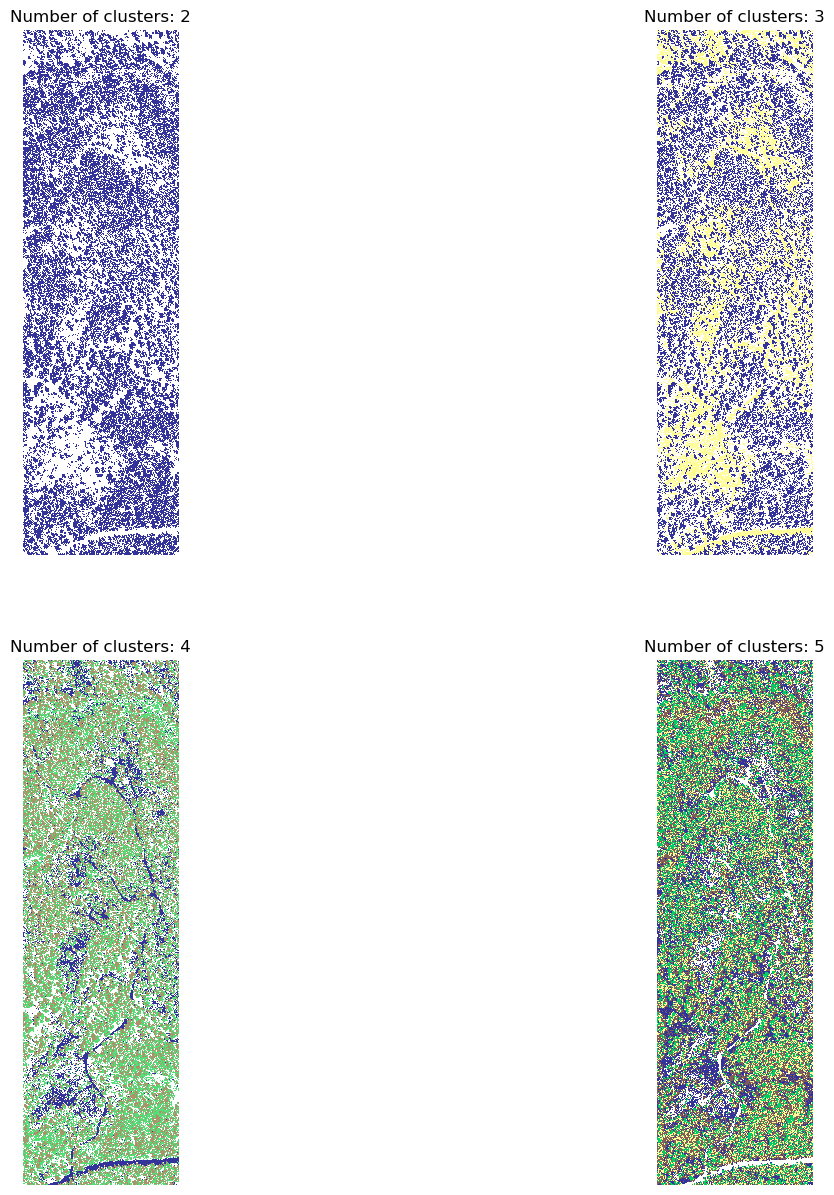

In [29]:
geotiff = "scratch/cropped_N4W351.tif"

# Load the TIFF file
with rasterio.open(geotiff) as src:
    # Assuming bands 1 to 4 are RGB and NIR
    bands = [src.read(i) for i in range(1, 5)]
    image_data = np.dstack(bands)

# Prepare the data for clustering
pixels = image_data.reshape((-1, 4))  # Flatten the image data for clustering

# Dictionary to store predictions
predictions = {}

# Perform K-means clustering for 2 to n clusters
for k in range(2, 6): 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image_data.shape[0], image_data.shape[1])
    predictions[k] = segmented_image

# Create a subplot grid and plot each clustering result
f, axes = plt.subplots(2, 2, figsize=(15, 15))  # Adjust subplot layout

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i >= 6:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction, cmap="terrain", interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
    ax.axis('off')  # Hide axis ticks

plt.show()

### Open Space Masking:

1.  **NDVI Calculation**:
    
    *   **Index Computation**: Using the Red and Near-Infrared (NIR) bands from the aerial imagery, the Normalized Difference Vegetation Index (NDVI) is calculated, which serves as a basis for distinguishing vegetated from non-vegetated areas.
2.  **Mask Application**:
    
    *   **Thresholding**: A threshold is applied to the NDVI results to create a binary mask, where values above a certain threshold (indicative of healthy vegetation) are marked as vegetated, and others as open spaces.
    *   **Morphological Operations**: Additional processing, such as opening or closing operations, may be applied to the binary mask to refine the edges and fill small gaps within vegetated areas.
3.  **Polygon Creation and Analysis**:
    
    *   **Vector Conversion**: The refined mask is then converted into vector format by delineating continuous vegetated or open space areas as polygons.
    *   **Spatial Analysis**: These polygons are analyzed to determine their area and other spatial properties, which can be used to assess habitat quality, fire risk, and other ecological or management parameters.



#### NDVI/Open Spaces Mask

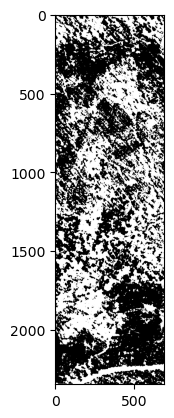

<Axes: >

In [30]:
image = rasterio.open(geotiff)

red = image.read(1).astype(float)
green = image.read(2).astype(float)
blue = image.read(3).astype(float)
nir = image.read(4).astype(float)
bands = np.dstack((red, green, blue, nir))
nbands = image.read().shape[0]
image.close()

ndvi = (nir - red) / (nir + red)
ndvi[np.isnan(ndvi)] = 0
open_spaces = ndvi >= 0.1

show(open_spaces, cmap='Greys')

#### Save as GeoTIFF

Credit: https://samgeo.gishub.org/

Source: https://github.com/opengeos/segment-geospatial/blob/4d1b12ec4c8a0a5d164bcb94a697c9af2dbcdecb/samgeo/common.py#L1417

In [31]:
def array_to_image(
    array, output, source=None, dtype=None, compress="deflate", **kwargs
):
    """Save a NumPy array as a GeoTIFF using the projection information from an existing GeoTIFF file.

    Args:
        array (np.ndarray): The NumPy array to be saved as a GeoTIFF.
        output (str): The path to the output image.
        source (str, optional): The path to an existing GeoTIFF file with map projection information. Defaults to None.
        dtype (np.dtype, optional): The data type of the output array. Defaults to None.
        compress (str, optional): The compression method. Can be one of the following: "deflate", "lzw", "packbits", "jpeg". Defaults to "deflate".
    """

    from PIL import Image

    if isinstance(array, str) and os.path.exists(array):
        array = cv2.imread(array)
        array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)

    if output.endswith(".tif") and source is not None:
        with rasterio.open(source) as src:
            crs = src.crs
            transform = src.transform
            if compress is None:
                compress = src.compression

        # Determine the minimum and maximum values in the array

        min_value = np.min(array)
        max_value = np.max(array)

        if dtype is None:
            # Determine the best dtype for the array
            if min_value >= 0 and max_value <= 1:
                dtype = np.float32
            elif min_value >= 0 and max_value <= 255:
                dtype = np.uint8
            elif min_value >= -128 and max_value <= 127:
                dtype = np.int8
            elif min_value >= 0 and max_value <= 65535:
                dtype = np.uint16
            elif min_value >= -32768 and max_value <= 32767:
                dtype = np.int16
            else:
                dtype = np.float64

        # Convert the array to the best dtype
        array = array.astype(dtype)

        # Define the GeoTIFF metadata
        if array.ndim == 2:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": 1,
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }
        elif array.ndim == 3:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": array.shape[2],
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }

        if compress is not None:
            metadata["compress"] = compress
        else:
            raise ValueError("Array must be 2D or 3D.")

        # Create a new GeoTIFF file and write the array to it
        with rasterio.open(output, "w", **metadata) as dst:
            if array.ndim == 2:
                dst.write(array, 1)
            elif array.ndim == 3:
                for i in range(array.shape[2]):
                    dst.write(array[:, :, i], i + 1)

    else:
        img = Image.fromarray(array)
        img.save(output, **kwargs)

In [32]:
mask_output = "ndvi-open-spaces.tif"
array_to_image(open_spaces, mask_output, source=geotiff)

#### K-Means Clustering (k = 2)

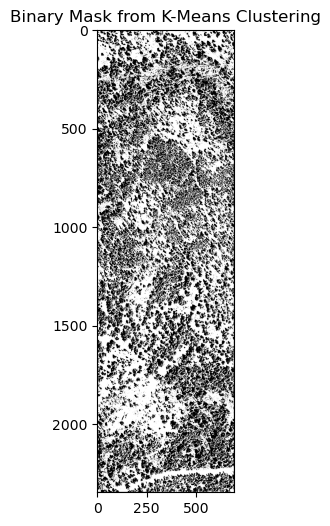

In [33]:
# Fit KMeans (k=2)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(pixels)
cluster_labels = kmeans.labels_
clustered_image = cluster_labels.reshape(image_data.shape[:2])

# Create binary mask for a specific cluster (e.g., cluster 0)
binary_mask = (clustered_image == 0).astype(np.uint8) * 255
binary_mask = binary_mask == 0

# Display the binary mask
plt.figure(figsize=(10, 6))
plt.imshow(binary_mask, cmap='Greys')
plt.title('Binary Mask from K-Means Clustering')
plt.show()

# Save the binary mask as a GeoTIFF
array_to_image(binary_mask, 'kmeans-open-spaces.tif', source=geotiff)

#### Segment Anything Model

Sources:
- https://github.com/facebookresearch/segment-anything
- https://github.com/opengeos/segment-geospatial

In [34]:
client = TileClient(geotiff)
t = get_leaflet_tile_layer(client)
m = Map(center=client.center(), zoom=client.default_zoom)
m.add(t)
m

Map(center=[40.2434655, -105.52648450000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [35]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None
)

In [36]:
mask = "segment-anything.tif"
sam.generate(
    geotiff, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|██████████| 10/10 [15:02<00:00, 90.23s/it]


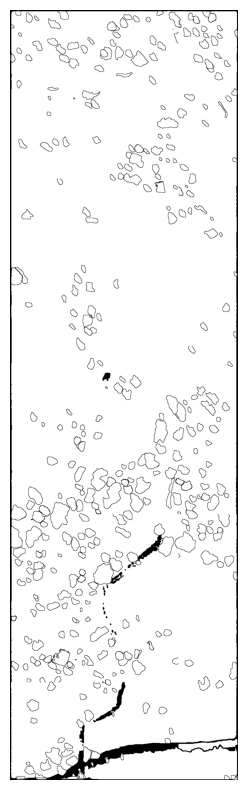

In [37]:
sam.show_masks(cmap="binary_r")

#### Calculate Acres of Open Space

In [38]:
ndvi_mask = 'ndvi-open-spaces.tif'
kmeans_mask = 'kmeans-open-spaces.tif'
segment_anything_mask = 'segment-anything.tif'

In [39]:
def geotiff_to_gdf(filepath):
    with rasterio.open(filepath) as src:
        mask = src.read(1).astype('uint8')
        mask_transform = src.transform
        geometries = list(shapes(mask, transform=mask_transform))
        shapes_list = [{'properties': {'raster_val': v}, 'geometry': shape(geom)}
                        for geom, v in geometries if v == 0]
        gdf = gpd.GeoDataFrame.from_features(shapes_list)
        gdf.crs = src.crs
    return gdf

def gdf_to_shp(gdf, out_path):
    gdf.to_file(out_path)

def calculate_area(gdf):
    gdf['area_feet'] = gdf.area
    gdf['area_acres'] = gdf['area_feet'] / 43560
    return gdf['area_acres']

In [40]:
files = [ndvi_mask, kmeans_mask, segment_anything_mask]
results = []

for file in files:
    filename = file
    gdf = geotiff_to_gdf(file)    
    gdf['area_acres'] = calculate_area(gdf)
    results.append(gdf)

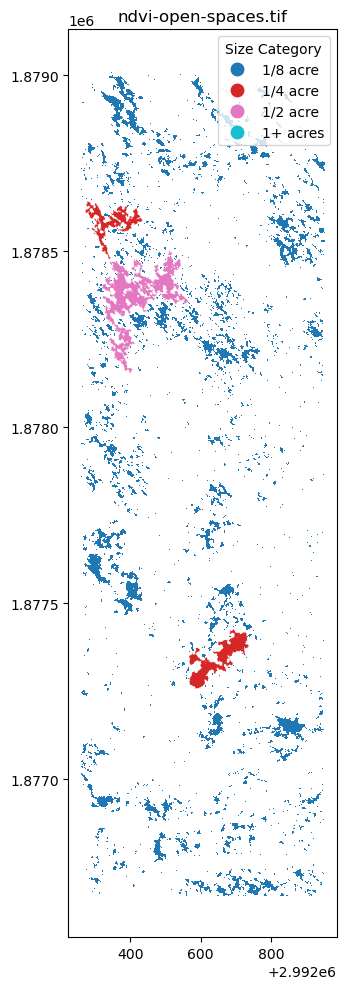

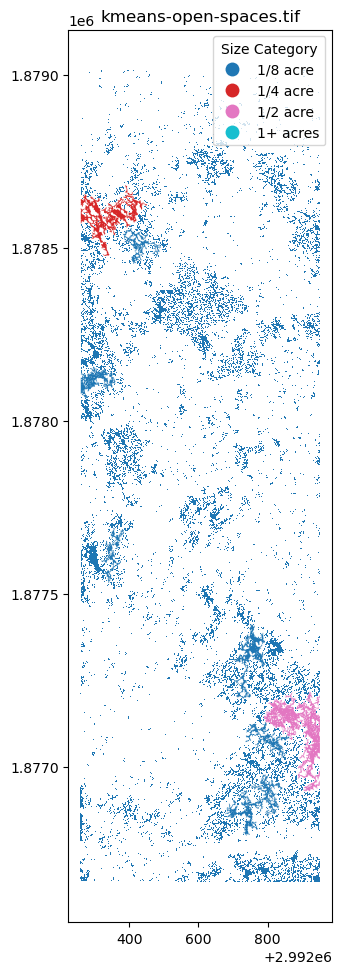

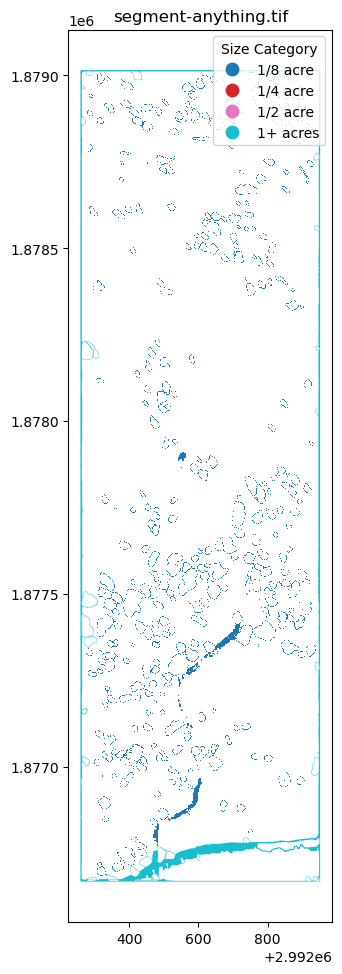

In [41]:
def bin_plot(gdf, bins, labels, title):
    gdf['size_category'] = pd.cut(gdf['area_acres'], bins=bins, labels=labels, right=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot = gdf.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
    ax.set_title(title)
    plt.tight_layout()
    filename = title.split('.')[0]
    plt.savefig(f'{filename}.png')
    plt.show()

for i, result in enumerate(results):
    bins = [0, 1/8, 1/4, 1/2, 1]
    labels = ['1/8 acre', '1/4 acre', '1/2 acre', '1+ acres']
    title = files[i]
    bin_plot(result, bins, labels, title)

### Creating Canopy Height Model from LiDAR Data:

1.  **LiDAR Data Processing**:
    
    *   **DEM Creation**: First return and ground return data from LiDAR are processed to create two separate digital elevation models (DEMs) – one representing the top canopy layer and the other the ground.
2.  **Canopy Height Calculation**:
    
    *   **Subtraction**: The ground DEM is subtracted from the first return DEM to generate a Canopy Height Model (CHM) which reflects the actual height of vegetation above the ground.
    *   **Data Cleaning**: This CHM is then processed to remove noise and artifacts, including applying filters to eliminate values that do not represent vegetation (e.g., negative values or extremely high anomalies).
    
### Important Note Regarding PDAL

This process requires PDAL (Point Data Abstraction Library) to be installed on the environment. This requires some extra steps beyond normal library installation:

* Install Visual Studio Build Tools:

* https://visualstudio.microsoft.com/visual-cpp-build-tools/

* run pip install pdal

* It may also be necessary to install cmake build tools from here:

* https://cmake.org/download/



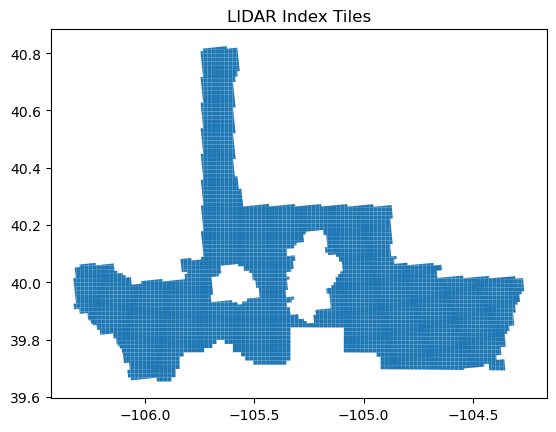

In [23]:
# Inport the LIDAR index grid and set up directories
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME)
project_dir = os.path.join(data_dir, "treebeard")
# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

las_index_path = os.path.join(
    data_dir,
    'earthpy-downloads',
    'lidar_index_cspn_q2',
    'lidar_index_cspn_q2.shp'
)

# Download LIDAR index tiles
if not os.path.exists(las_index_path):
    las_index_url = ('https://gisdata.drcog.org:8443/geoserver/DRCOGPUB/'
             'ows?service=WFS&version=1.0.0&request=GetFeature&'
             'typeName=DRCOGPUB:lidar_index_cspn_q2&outputFormat=SHAPE-ZIP')

    las_index_shp = et.data.get_data(url=las_index_url)

las_index_gdf = (
    gpd.read_file(las_index_path).set_index('tile')
#    .loc[['N3W345']]
)

las_index_gdf = las_index_gdf.to_crs('EPSG:4269')

# las_index_plot = las_index_gdf.hvplot(
#     tiles = 'OSM',
#     geo = True,
#     line_color='black',
#     line_width=2,
#     fill_alpha=0
# )
# las_index_plot

las_index_gdf.plot()
plt.title("LIDAR Index Tiles")

plt.show()

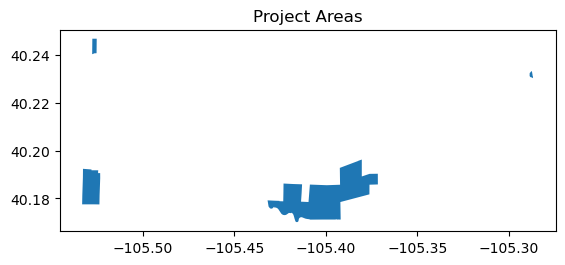

In [25]:
# Open project areas shapefile and plot
proj_zip_path = 'assets/project_areas_merged.zip'

with zipfile.ZipFile(proj_zip_path, 'r') as zip_ref:
    temp_dir = '/tmp/extracted_shapefile'  # You can specify any temporary directory
    zip_ref.extractall(temp_dir)
    
extracted_shapefile_path = temp_dir + '/'

proj_area_gdf = gpd.read_file(extracted_shapefile_path)

proj_area_gdf = proj_area_gdf.to_crs("EPSG:4326")

# proj_area_plot = proj_area_gdf.hvplot(
#     x='x',
#     y='y',
#     aspect='equal',
#     tiles='EsriImagery',
#     geo=True,
#     line_color='blue',
#     line_width=2,
#     fill_alpha=0
# )

# proj_area_plot

proj_area_gdf.plot()

plt.title("Project Areas")

plt.show()

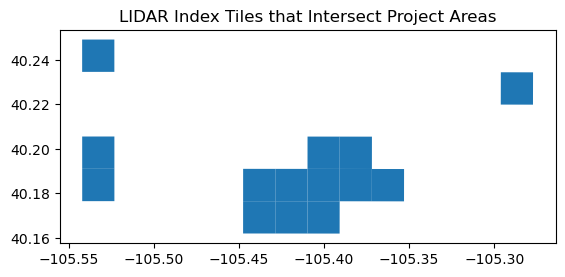

In [27]:
# Identify the tiles that intersect each project area
select_tiles_gdf = gpd.sjoin(las_index_gdf, proj_area_gdf, how='inner', op='intersects')

select_tiles_gdf.reset_index(drop=False)
# select_tiles_gdf.hvplot(
#     x='x',
#     y='y',
#     aspect='equal',
#     tiles='EsriImagery',
#     geo=True,
#     line_color='blue',
#     line_width=2,
#     fill_alpha=0
# )

select_tiles_gdf.plot()

plt.title("LIDAR Index Tiles that Intersect Project Areas")

plt.show()

In [28]:
select_tiles_gdf = select_tiles_gdf.reset_index(drop=False)

In [29]:
# Generate list of all tiles per project area
tiles_by_area = select_tiles_gdf.groupby('Proj_ID')['tile'].apply(list).reset_index()
tiles_by_area

,Proj_ID,tile
0,Conifer Hill,"[N4W399, N4W397, N4W389, N4W396, N4W388, N4W29..."
1,Unnamed 1,[N4W264]
2,Unnamed 2,"[N4W381, N4W391]"
3,Zumwinkel,[N4W351]


In [ ]:
# Use PDAL to process LAS files into ground and first returns TIFs
def convert_las_to_tif(input_las, output_tif, return_type):
    """
    Process a LAS file into a GeoTIFF based on specified return type.

    Parameters:
    - input_las (str): Path to the input LAS file.
    - output_tif (str): Path to save the output GeoTIFF file.
    - return_type (str): Type of returns to process ("first" or "ground").

    Returns:
    - None
    """
    
    def get_crs_from_las(input_las):
        """
        Get the Coordinate Reference System (CRS) information from the header of a LAS file.

        Parameters:
        - input_las (str): Path to the input LAS file.

        Returns:
        - crs (str): The CRS information.
        """
        pipeline = {
            "pipeline": [
                {
                    "type": "readers.las",
                    "filename": input_las
                }
            ]
        }

        pipeline_manager = pdal.Pipeline(json.dumps(pipeline))
        pipeline_manager.execute()

        metadata = pipeline_manager.metadata
        if "metadata" in metadata and "readers.las" in metadata["metadata"]:
            crs = metadata["metadata"]["readers.las"]["comp_spatialreference"]
        else:
            crs = None

        return crs

    # Get CRS from LAS header
    crs_info = get_crs_from_las(input_las)
    
    # Define PDAL pipeline in JSON format based on return type
    if return_type == "first":
        pipeline = {
            "pipeline": [
                {
                    "type": "readers.las",
                    "filename": input_las
                },
                {
                    "type": "filters.range",
                    "limits": "ReturnNumber[1:1]"  # Filter for first returns
                },
                {
                    "type": "writers.gdal",
                    "filename": output_tif,
                    "resolution": 1,  # Adjust as needed
                    "output_type": "idw"  # Interpolation method (Inverse Distance Weighting)
                    #"crs": crs_info
                }
            ]
        }
    elif return_type == "ground":
        pipeline = {
            "pipeline": [
                {
                    "type": "readers.las",
                    "filename": input_las
                },
                {
                    "type": "filters.range",
                    "limits": "Classification[2:2]"  # Filter for ground returns
                },
                {
                    "type": "writers.gdal",
                    "filename": output_tif,
                    "resolution": 1,  # Adjust as needed
                    "output_type": "idw"  # Interpolation method (Inverse Distance Weighting)
                    #"crs": crs_info
                }
            ]
        }
    else:
        raise ValueError("Invalid return_type. Use 'first' or 'ground'.")

    # Execute PDAL pipeline
    pipeline_manager = pdal.Pipeline(json.dumps(pipeline))
    pipeline_manager.execute()

In [ ]:
# Process tiles for each project area
# Generate a dictionary of canopy TIFs for each project area

las_root_url = 'https://lidararchive.s3.amazonaws.com/2020_CSPN_Q2/'
canopy_dict = {}
for index, row in tiles_by_area.iterrows():
    tiles = row['tile']
    proj_area_name = row['Proj_ID']
    sel_proj_area_gdf = proj_area_gdf[proj_area_gdf['Proj_ID'] == proj_area_name]
    # Download all tiles for project area, process, and clip/merge
    tile_agg = []
    print("Processing LIDAR for " + proj_area_name)
    for tile in tiles:
        file_name = tile + ".las"
        print("Processing LIDAR tile " + tile)
        tile_path = os.path.join(
            data_dir,
            'earthpy-downloads',
            file_name
        )
        download_url = las_root_url + tile + ".las"
        if not os.path.exists(tile_path):
            et.data.get_data(url=download_url)
        # PDAL is required for this step, see readme for install instructions

        # Output path for first returns DEM
        output_fr_tif = os.path.join(
            project_dir,
            tile +'_fr.tif'
        )
        if not os.path.exists(output_fr_tif):
            convert_las_to_tif(tile_path, output_fr_tif, "first")
        
        # Output path for ground DEM
        output_gr_tif = os.path.join(
            project_dir,
            tile +'_gr.tif'
        )
        if not os.path.exists(output_gr_tif):
            convert_las_to_tif(tile_path, output_gr_tif, "ground")
        
        # Process ground and first return data to canopy height
        fr_dem = rxr.open_rasterio(output_fr_tif)
        fr_dem = fr_dem.rio.reproject("EPSG:4326")

        gr_dem = rxr.open_rasterio(output_gr_tif)
        gr_dem = gr_dem.rio.reproject("EPSG:4326")
        gr_dem = gr_dem.rio.reproject_match(fr_dem)

        canopy_dem = fr_dem - gr_dem

        # canopy_dem = canopy_dem.where(canopy_dem >= 1, -9999)
        # canopy_dem = canopy_dem.where(canopy_dem <= 500, np.nan)
        # Set all values greater than 1 (canopy) to 1 and all values less than 1 (no canopy) to 0
        canopy_dem.values[canopy_dem < 1] = 0
        canopy_dem.values[canopy_dem > 1] = 1
        canopy_dem.name = tile + "_Canopy"
        canopy_dem = canopy_dem.round()
        tile_agg.append(canopy_dem)
    print("Merging LIDAR tiles for " + proj_area_name)
    # Merge all tiles that intersect with the project area and clip to project area
    canopy_merged = rxrm.merge_arrays(tile_agg).rio.clip(sel_proj_area_gdf.geometry)
    canopy_dict[proj_area_name] = canopy_merged        

In [ ]:
# Export Zumwinkel canopy tif to repo
test = canopy_dict['Zumwinkel']

zumwinkel_path = "../notebooks/zumwinkel_canopy.tif"

if not os.path.exists(zumwinkel_path):
    test.rio.to_raster(zumwinkel_path)

## Plotting Canopy Height for the Zumwinkel Site

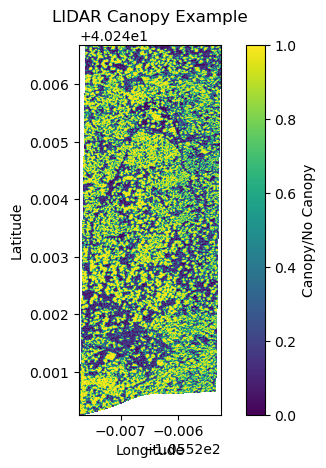

In [40]:
import rioxarray as rxr 
import hvplot.xarray
import cartopy
import geoviews

# Plot Zumwinkel canopy tif
zumwinkel_path = "./notebooks/zumwinkel_canopy.tif"

zumwinkel_lidar = rxr.open_rasterio(zumwinkel_path).rio.reproject("EPSG:4326")
# zumwinkel_lidar.hvplot(
#     height=600,
#     width=600,
#     geo=True,
#     #rasterize=True,
#     aspect='equal',
#     kind='image',
#     tiles = 'EsriImagery',
#     alpha=0.5,
#     title = "LIDAR Canopy Example",
#     clabel= 'Height in feet',
#     # crs = canopy_dem.rio.crs
# )

# Get the resolution of the raster in degrees
resolution = abs(zumwinkel_lidar.rio.resolution()[0])

# Calculate the width and height of the raster in latitude and longitude
width = zumwinkel_lidar.sizes['x'] * resolution
height = zumwinkel_lidar.sizes['y'] * resolution

# Plot the raster with aspect ratio based on width and height
plt.imshow(zumwinkel_lidar[0], cmap='viridis', extent=[lon_min, lon_min + width, lat_min, lat_min + height])
plt.colorbar(label='Canopy/No Canopy')
plt.title('LIDAR Canopy Example')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Current Issues / Bugs
---------------------

### Known Challenges:

*   **Polygon Conversion**: We are encountering issues in converting clustered data and canopy height models into polygon formats.
    
*   **Plot Rendering**: There are inconsistencies in how plots are rendered within the Jupyter Notebook, particularly with `shapely` and `cartopy` struggling to display maps from the resulting TIFF files.
    
*   **Compatibility and Docker Issues**: Ongoing efforts are being made to address compatibility issues related to Docker configurations.
    
*   **Clustering Anomalies**: Minor details, such as small holes within open spaces, are disrupting the clustering process. Adjusting the resampling or reconfiguring the clustering setup may be required.
    
*   **Disjointed Clustering**: Areas that should be connected are being segmented into separate clusters due to the algorithm establishing more cluster centers than necessary. Exploring different clustering methods might provide a solution.
    
*   **Interference by Manmade Structures**: Manmade structures like buildings are distorting spatial computation results. Temporarily excluding these from the analysis and reintegrating them later might be necessary for accurate spatial analysis.

*   **Determine correct method of LIDAR analysis and presentation**: We are interested in the gaps between canopied areas. Should these be set to NAN or given a value so they can be extracted to polygons? The plot above sets a value for 0 to non canopied areas and 1 for canopied areas for illustrative purposes

*  **Draw Better Polygons**:  We need to draw better polygons around the areas of interest.  This will require a more robust method of clustering and polygon drawing.  We are currently working on this.

*  **Better Grouping/Binning of Openings**:  We need to better group the openings into larger polygons.  This will require a more robust method of clustering and polygon drawing.  We are currently working on this.
    

Further Development
-------------------

### Development Goals:

*   **Debugging**: Address current technical issues to enhance data integration and analysis accuracy.
    
*   **Data Pipeline**: Establish a robust pipeline to consistently produce clean and usable polygon data from aerial photography and LiDAR sources, both user-supplied and publicly available.
    
*   **Methodology Enhancement**: Investigate alternative methods for clustering and Digital Elevation Model (DEM) generation to ensure the polygons accurately reflect the surveyed landscapes.
    
*   **Metrics and Calculations**: Define and implement metrics for calculating spatial heterogeneity based on the compiled data.
    
*   **Data Reporting**: Develop a system to measure, store, and report the calculated data effectively.
    
*   **Results Interpretation**: Create mechanisms that allow users to interpret results flexibly and meaningfully regarding spatial composition.
    
*   **Plugin Integration**: Develop and integrate a user-friendly plugin for QGIS that enables users to easily load data and execute analyses.
    
*   **Dependency Management**: Ensure that all necessary dependencies are included in the final product to facilitate end-user operations.
    
*   **Open-Source Contribution**: Aim to deliver an open-source QGIS plugin that categorizes tree clusters from raster mosaic data into a structured shapefile. This tool should enable the automatic processing of these data into spatial composition algorithms to assess various ecological metrics.
    

Citations
---------

### Data References:

*   **Aerial Data**: "Denver Regional Aerial Photography Project (DRAPP)", Denver Regional Counsel of Governance, 2020. [Available online](https://data.drcog.org/dataset/denver-regional-aerial-photography-project-tiles-2020).
    
*   **LiDAR Data**: "DRCOG LIDAR QL2 INDEX IN CO SP NORTH 2020", Denver Regional Counsel of Governance. [Available online](https://data.drcog.org/dataset/lidar-ql2-index-in-co-sp-north-2020).



In [26]:
%%capture
%%bash
jupyter nbconvert treebeard.ipynb --to html